In [26]:
from os.path import join
import json

import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

from data_extent import data, folders

In [55]:
def rasterio_index(rect, src):
    ul = src.index(rect[0], rect[3])
    lr = src.index(rect[1], rect[2])

    minx = min(ul[0], lr[0])
    maxx = max(ul[0], lr[0])
    miny = min(ul[1], lr[1])
    maxy = max(ul[1], lr[1])

    if miny == maxy:
        print("I'm bad!", rect[2], rect[3], miny, maxy, minx, maxx)

    return [minx, maxx, miny, maxy]

In [56]:
def window_ordered_coords(bbox):
    # ymin, ymax, xmin, xmax
    return ((bbox[0], bbox[2]), (bbox[1], bbox[3]))


def bbox_ordered_coords(rect):
    # xmin, ymax, xmax, ymin
    return rect[0], rect[2], rect[1], rect[3]

In [57]:
def expand_window_no_offset(bbox):
    return [bbox[0] - 128, bbox[0] + 128, bbox[2] - 128, bbox[2] + 128]

In [64]:
def main():
    # Setting up paths
    datasets_path = '/home/annie/Data/datasets/planet_ships/singapore'
    img_ind = 10  # Select tif #10 for this notebook
    dir_path = join(datasets_path, folders[img_ind]) + '/'
    img_name = data[img_ind][0]
    img_corners = data[img_ind][1]
    src_path = dir_path + 'test_' + str(img_ind) + '.tif'  # warped data
    ogr_path = dir_path + 'ships_ogr_' + str(img_ind) + '.geojson'

    # Opening source tif and GeoJSON
    src_ds = rasterio.open(src_path)
    with open(ogr_path) as ogr:
        ogr_dict = json.load(ogr)

    # Making GeoJSON polygon manipulable
    rect = ogr_dict['features'][::2][6]  # First feature: ADJUST THIS VALUE
    rect_js = rect['geometry']['coordinates'][0]
    bbox_coords = [min(rect_js[0][0], rect_js[1][0]),  # minX/left
        max(rect_js[0][0], rect_js[1][0]),  # maxX/right
        min(rect_js[0][1], rect_js[2][1]),  # minY/bottom
        max(rect_js[0][1], rect_js[2][1])]  # maxY/top
    
    
    bbox_pixels = rasterio_index(bbox_coords, src_ds)
    chip_corners = expand_window_no_offset(bbox_pixels)
    
    print("Coordinates: ", bbox_coords)
    print("Pixel translation: ", bbox_pixels)
    print("Chip corners (by pix in tif): ", chip_corners)
        
    ship_box = rasterio.coords.BoundingBox(*bbox_ordered_coords(bbox_pixels))
    chip_box = rasterio.coords.BoundingBox(*bbox_ordered_coords(chip_corners))
    mask = window_ordered_coords(chip_box)
        
    # Convert ship pixel location to location inside chip
    relative_ship = [ship_box[0] - chip_box[0], ship_box[2] - chip_box[0],
                     ship_box[1] - chip_box[1], ship_box[3] - chip_box[1]]
    
    print("Ship location in chip: ", relative_ship)

    
    # Rescale image for plot display
    mask_img = src_ds.read([3, 2, 1], window=mask)
    rescale_img = np.reshape(mask_img, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 255))
    rescale_img = scaler.fit_transform(rescale_img)
    mask_img_scaled = (np.reshape(rescale_img, mask_img.shape)).astype(np.uint8)
                                               
    # Create figure and axes
    fig, ax = plt.subplots(1)
    rect = patches.Rectangle((relative_ship[0], relative_ship[2]), relative_ship[1] - relative_ship[0],
                              relative_ship[3] - relative_ship[2],
                              linewidth=4, edgecolor='r',
                              facecolor='none')
    ax.add_patch(rect)

    plt.imshow(mask_img_scaled.T, origin='lower')

    plt.show()

("I'm bad!", 1.315732090870315, 1.316662127553772, 4968, 4968, 3013, 3047)
('Coordinates: ', [103.60424554457964, 103.6042460615384, 1.315732090870315, 1.316662127553772])
('Pixel translation: ', [3013, 3047, 4968, 4968])
('Chip corners (by pix in tif): ', [2885, 3141, 4840, 5096])
('Ship location in chip: ', [128, 162, 128, 128])


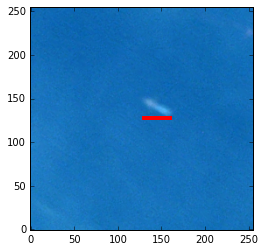

In [65]:
main()